## 2.4 简单的小作业

只是用于验证你确实了解了这些关于 Julia 的基本语法

In [ ]:
using BenchmarkTools

## 1. Fibonacci 数

这是 fibonacci 数的基本定义：

- fib(n) = fib(n-1) + fib(n-2)
- fib(1) = 1
- fib(2) = 1

任务：实现一个 fibonacci 函数 `fib` 并构造所有 N 以内为偶数的 fibonacci 数的数列，例如：当 `N = 50` 时，你的结果应该是 `[2, 8, 34]`

因为 fibonacci 的递归特性，每次计算 `f(n)` 的时候都会重复计算一次 `f(n-1)` 和 `f(n-2)`，一个很自然的避免重复计算的方案就是将计算的结果存储下来，并通过查表的方式得到结果。

可以两种方法都实现一下，然后利用 `@time` 或者 `@btime`(需要 `using BenchmarkTools`) 来对比两种方法的时间和空间开销。

In [ ]:
function fib1(n)
    if n == 1 || n == 2
        return 1
    end
    return fib1(n-1) + fib1(n-2)
end

fib1 (generic function with 1 method)

In [ ]:
function f1(N)
    ans = zeros(Int64,0)
    i = 1
    while true
        x = fib1(i)
        if x > 50
            return ans
        elseif x % 2 == 0
            append!(ans, x)
        end
        i += 1
    end
end
@btime f1(50)

  481.026 ns (2 allocations: 128 bytes)


3-element Vector{Int64}:
  2
  8
 34

In [ ]:
global F = zeros(Int64,100)
F[1],F[2] = 1,1
function fib2(n)
    for i in 3:n
        F[i] = F[i-1] + F[i-2]
    end
    return F[n]
end

fib2 (generic function with 2 methods)

In [ ]:
function f2(N)
    ans = zeros(Int64,0)
    i = 1
    while true
        x = fib2(i)
        if x > 50
            return ans
        elseif x % 2 == 0
            append!(ans, x)
        end
        i += 1
    end
end
@btime f2(50)

  3.138 μs (2 allocations: 128 bytes)


3-element Vector{Int64}:
  2
  8
 34

### 2. 函数插值

假设知道函数 `f` 在 `X = [x1, x2, ..., xn]` 处的值 `[c1, c2, ..., cn]`，使用任何你知道的插值方式，构造函数在 `minimal(X):0.01:maximum(X)` 上的结果并绘制对应的曲线

例如最简单的插值方式是线性插值，即对于 `(x1, x2)` 来说，构造一次函数 `f(x) = ax+b` 使得 `f(x1) == c1` 以及 `f(x2) == c2`.

In [2]:
X1 = 1.5 .* randn(200) .+ 3
C = sin.(X1);

In [3]:
# Julia takes a lot of time to plot the first figure
using Plots

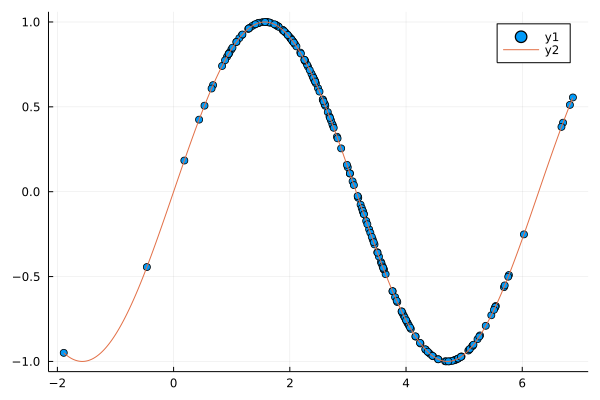

In [4]:
# 理想曲线是
scatter(X1, C)
X2 = minimum(X1):0.01:maximum(X1)
plot!(X2, sin.(X2))

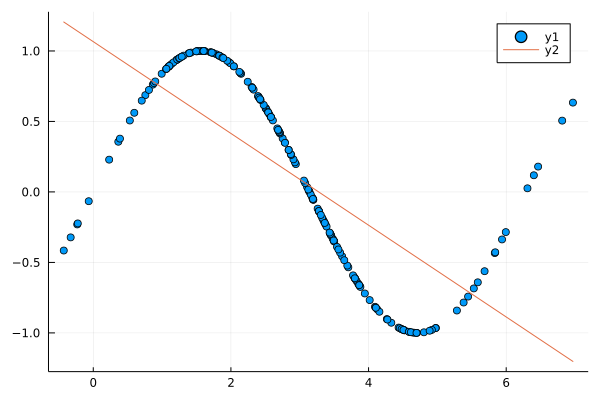

In [ ]:
# Linear Model - LSE
scatter(X1, C)
β1 = sum((X1 .- mean(X1)).*(C .- mean(C))) / sum((X1 .- mean(X1)) .^ 2)
β0 = mean(C) - mean(X1) * β1
Ĉ = β0 .+ X1 .* β1
plot!(X1, Ĉ)

## 3. 梯度下降法

通过梯度下降法求解函数 `f` 的最小值按照以下方式进行：

1. 设定初值 `x0`
2. 计算 `f` 在 `x0` 处的导数 Δf
3. `x0 = x0 - ηΔf`, `η` 为步长

循环 2, 3 直到满足终止条件。

任务：

1. 对于给定函数 `f(x) = sin(x)^3 + 5x^2 + x`, 实现 `optimize_f(x0, η=0.01)` 函数，使用梯度下降法求解 `f` 的最小值。
2. 实现一个 `optimize(f, x0, η=0.01)` 的函数，使用梯度下降法来求解**任意**标量函数 `f` 的最小值，并构造其他函数来验证结果。[Zygote.jl](https://github.com/FluxML/Zygote.jl) 是一个自动微分框架，可以用来快速计算"任意"函数的导数。

In [5]:
f(x) = sin(x)^3 + 5x^2 + x
grad_f(x) = 3cos(x)sin(x)^2 + 10x + 1

function optimize_f(x0, η=0.01)
    x = x0
    
    nothing
    
    return x
end

optimize_f (generic function with 2 methods)

In [6]:
using Zygote

In [7]:
# 除了返回值是元组以外，等价于 grad_f(0.3)
∇f = gradient(f, 0.3)

(4.250294890641206,)

In [8]:
function optimize(f, x0, η=0.01)
    x = x0
    
    nothing
    
    return x
end

optimize (generic function with 2 methods)